# Group 1 Project

## Business Case

**Authors**

Jon Rasiko, Joel Ruetas, Samiha Simran, Amina Robi

**Abstract**

Text classification is the process of assigning text documents into two or more categories. The most common form is binary classification or assigning one of two categories to all documents in the corpus. This project uses binary classification to assign websites as either benign or malicious.


**Background**

Phishing is defined as “the practice of tricking Internet users (as through the use of deceptive email messages or websites) into revealing personal or confidential information which can then be used illicitly” (Definition of phishing, 2023). According to (Rosenthal, 2022), “96% of phishing attacks arrive by email. Another 3% are carried out through malicious websites and just 1% via phone”. The frequency and costs associated phishing and ransomware attacks have increased year after year:

* In 2020, 6.95 million new phishing and scam pages were created, with the highest number of new phishing and scam sites in one month of 206,310. The average ransom paid increased 171% from 2019 to 2020 (\$115,123 to \$312,493), said the 2021 Unit 42 Ransomware Threat Report.
* By September 2020, the average ransom payment peaked at $233,817, according to the 2021 Webroot BrightCloud Threat Report. The report also found that phishing spiked by 510 % from January to February 2020 alone.
* According to the Sift Q1 2021 Trust & Safety Index, in 2020 the pandemic increased online giving by 20.7%. This increase in traffic provided cover to fraudsters that hid behind transaction surges:
    * Ransomware attacks grew by over 40%.
    * Email malware attacks were up by 600% compared to 2019. 

Improving the detection and reporting of phishing emails/URLs is a critical requirement to reduce the success rate of social engineering attacks, which are the number 1 cause of compromise on corporate networks. Reducing the success rate of social engineering attacks also reduces any potential impact of costs associated with ransomware attacks and the legal and reputation costs associated with the disclosure of private data.

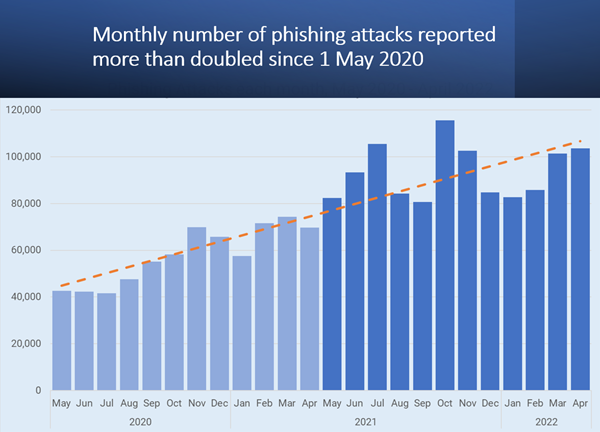

**Objective**

The objective is to use text classification models to determine if
websites are benign or malicious. This will allow us to improve detection and reporting of phishing websites so we are in better position reduce the
rate of social engineering attacks and leakage of private
data.

## Requirements

Before proceeding, you will be required to install some Python modules. The notebook requires the modules below, which can be installed by executing the code block below.

* `pycaret`
* `nltk`

In [1]:
%%capture
!pip install --upgrade pip
!pip install pycaret nltk

# Download the required NLTK documents
import nltk

nltk.download('stopwords')
nltk.download('punkt')

## Overall Process

Here are the general steps to classify a large number of webpages using pycaret:

1. **Collect and preprocess the data**: Collect the webpages that need to be classified and preprocess them to extract the relevant information. This may involve cleaning the text data, removing stop words, and transforming the data into a format that can be used by `pycaret.
1. **Load the data into a pandas `DataFrame`**: Load the preprocessed data into a pandas `DataFrame`.
1. **Generate the `CountVectorizer`**: Generate the token count vector to append to other features. This involve filtering some of the rows in the `DataFrame`.
1. **Set up the `pycaret` environment**: Initialize the `pycaret` environment and load the data using the `setup()` function. This function automatically preprocesses the data and prepares it for modeling.
1. **Train and compare multiple models**: Train multiple classification models using the `compare_models()` function. This function automatically trains and evaluates several models and selects the best one based on performance metrics.
1. **Tune the selected model**: Use the `tune_model()` function to fine-tune the selected model and improve its performance.
1. **Evaluate the model**: Evaluate the final model on the testing set using the `evaluate_model()` function.
1. **Save the model**: Save the trained model to a file using the `save_model()` function so that it can be reused later.
1. **Deploy the model**: Deploy the trained model in a production environment and use it to classify webpages as needed.
1. **Use the model to classify new data**: Once the final model is trained and evaluated, use it to classify new webpages using the `predict_model()` function.


## Preprocessing

The preprocessing steps for webpages for this project include the following activities:

1. Retrieving the raw HTML content of each webpage using `BeautifulSoup`.
1. Cleaning the HTML content by removing HTML tags, script and style tags, and other unwanted content using regular expressions;
1. Tokenizing the cleaned HTML content into words or phrases using `NLTK`.
1. Normalizing the tokens by converting them to lowercase, removing punctuation, and removing stop words (common words that do not add meaning to the text).

This process is done using the dataset made available [Phishing and benign websites samples for phishing detection](https://www.kaggle.com/datasets/asifejazitu/phishing-dataset) dataset, which holds 382,000 webpages from [PhishTank](https://phishtank.org/phish_detail). While all the webpages were pre-processed and recorded into a CSV file, the model is training only on a subset due to limited time and computing resources.

While preprocessing the webpages, we also extracted additional features that may be useful in identifying phishing websites. These includes:

* `title_raw`. The contents of the `<title>` element.
* `is_english`. Uses the `langdetect` module to assess whether the webpage is in English.
* `has_form`. Specify whether the web page contains one or more `<form>` objects.
* `has_login_form`. Specify whether the webpage contains one or more `<form>` objects containing an `input` of type `password`.
* `has_js`. Specify whether the webpage contains one or more `<javascript>` object.
* `js_include_b64`. Specify whether or not the `<javascript>` objects contains base64-encoded strings.
* `nb_tokens`. Number of tokens remaining after the initial cleaning up of the parsing phase.

All these values are saved as columns into the resulting CSV along with the tokens extracted from the text. 

**Note**. As it is often the case with webpages, the HTML is not always parsed cleanly, resulting in HTML remaining in the tokens. Better parsing is an improvement left for further version.

This step is omitted in this notebook, but is implemented in the [final app](https://github.com/DeepCodeSec/ml1000-p3). The dataset can be combined into one (1) CSV file by executing the following commands:

```sh
$ python app.py --parse ./data/sample/malicious --class malicious
$ python app.py --parse ./data/sample/benign --class benign
$ cp ./data/data-benign.csv ./data/data.csv
$ tail -n +2 ./data/data-malicious.csv >> ./data/data.csv
```

For the purpose of demonstration, a sample of 20,000 rows is used to generate an initial model. You can specify the sample file below:

In [4]:
#@title Data Source
datafile = "./data-sample-20K.csv" #@param {type:"string"}

In [5]:
import pandas as pd

# Load the pre-processed data into the `df_features_ datafram
df_features = pd.read_csv(datafile, sep=',')
print(f"Dataset '{datafile}' contains {df_features.shape[0]} row(s) and {df_features.shape[1]} column(s).")

Dataset './data-sample-20K.csv' contains 19997 row(s) and 48 column(s).


In [9]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_clean         17066 non-null  object 
 1   is_english          19997 non-null  int64  
 2   img_count           19997 non-null  int64  
 3   has_form            19997 non-null  int64  
 4   has_login_form      19997 non-null  int64  
 5   has_js              19997 non-null  int64  
 6   js_include_b64      19997 non-null  int64  
 7   nb_tokens           19997 non-null  int64  
 8   text_clean          19461 non-null  object 
 9   classification      19997 non-null  object 
 10  nb_title_entities   19997 non-null  float64
 11  nb_text_entities    19997 non-null  float64
 12  jpmorgan_chase      19997 non-null  float64
 13  bank_of_america     19997 non-null  float64
 14  wells_fargo         19997 non-null  float64
 15  hsbc                19997 non-null  float64
 16  deut

In [8]:
df_features.describe()

,is_english,img_count,has_form,has_login_form,has_js,js_include_b64,nb_tokens,nb_title_entities,nb_text_entities,jpmorgan_chase,...,youtube,whatsapp,facebook_messenger,wechat,instagram,tiktok,qq,weibo,linkedin,twitter
count,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,...,19997.000000,19997.000000,19997.0,19997.0,19997.000000,19997.0,19997.0,19997.0,19997.000000,19997.000000
mean,0.834475,8.605641,0.651348,0.519628,0.824674,0.023153,363.717108,0.100115,15.067510,0.000650,...,0.000700,0.003050,0.0,0.0,0.000100,0.0,0.0,0.0,0.008701,0.041706
std,0.371663,30.463142,0.476556,0.499627,0.380255,0.150395,2004.545679,0.307729,49.484042,0.025489,...,0.026451,0.055148,0.0,0.0,0.010001,0.0,0.0,0.0,0.092876,0.199922
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,28.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,1.000000,6.000000,1.000000,1.000000,1.000000,0.000000,186.000000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
max,1.000000,1639.000000,1.000000,1.000000,1.000000,1.000000,115550.000000,4.000000,1770.000000,1.000000,...,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,1.000000


In [6]:
display(df_features.head(5))

,title_clean,is_english,img_count,has_form,has_login_form,has_js,js_include_b64,nb_tokens,text_clean,classification,...,youtube,whatsapp,facebook_messenger,wechat,instagram,tiktok,qq,weibo,linkedin,twitter
0,one drive,1,1,0,0,1,0,31,one drive read document please choose email pr...,malicious,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,american express : online service : log in,1,3,1,1,1,0,5,american express online service log,malicious,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"alibabamanufacturerdirectory-suppliers , manuf...",1,6,1,1,1,0,168,alibabamanufacturerdirectory-suppliers manufac...,malicious,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,...,1,2,0,1,1,0,6,... session expired password keep logged,malicious,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,1,6,1,1,0,0,7,gjin.jung samsung.com 3c 95338 2017 icp0803424...,malicious,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
display(df_features.tail(5))

,title_clean,is_english,img_count,has_form,has_login_form,has_js,js_include_b64,nb_tokens,text_clean,classification,...,youtube,whatsapp,facebook_messenger,wechat,instagram,tiktok,qq,weibo,linkedin,twitter
19992,retarus enterprise administration service,1,3,1,1,1,0,4,retarus enterprise administration service,benign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19993,squadzip,1,6,1,1,1,0,93,squadzip sign english english bahasa indonesia...,benign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19994,preference center,1,0,1,0,1,0,22,preference center preference center f e am.jll...,benign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19995,NaN,1,0,1,0,1,0,20,'ve detected javascript disabled browser would...,benign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19996,NaN,1,0,0,0,1,0,63,welcome citi 's digital research product engli...,benign,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One of the first filtering decision we will make is to control the number of tokens to analyze by eliminating outliers in terms of token size. As such, let's review the `nb_tokens` column.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

nb_tokens = df_features['nb_tokens']
min_tokens = nb_tokens.min()
max_tokens = nb_tokens.max()
mean_tokens = nb_tokens.mean()
median_tokens = nb_tokens.median()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)

Minimum number of tokens: 0
Maximum number of tokens: 115550
Mean number of tokens: 363.7171075661349
Median number of tokens: 28.0


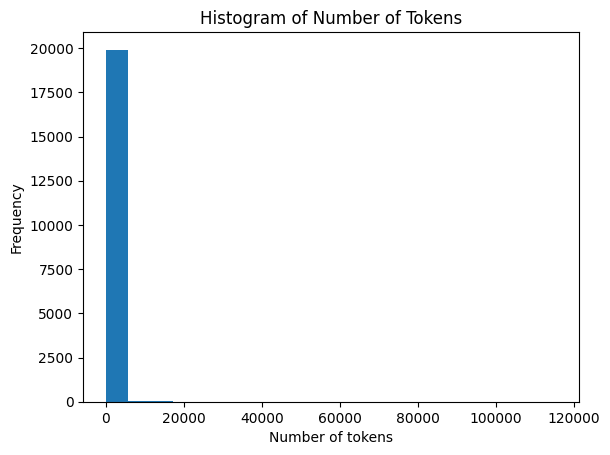

In [11]:
plt.hist(nb_tokens, bins=20) # 20 is the number of bins you want to use
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens')
plt.show()

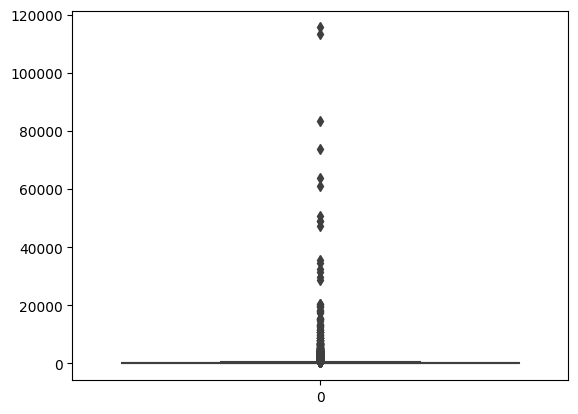

In [12]:
plt.figure()
sns.boxplot(df_features['nb_tokens'])
plt.show()


As we can see, there are a very small number of very large documents which will need to be removed as most have around 40 tokens

In [ ]:
#@title Filtering Options
min_tokens = 7 #@param { type:"integer" }
max_tokens = 70 #@param { type:"integer" }

In [ ]:
# Find out a range for `nb-tokens`
df_tokens = df_features[(df_features['nb_tokens'] >= min_tokens) & (df_features['nb_tokens'] <= max_tokens)]

nb_tokens = df_tokens['nb_tokens']
min_tokens = nb_tokens.min()
max_tokens = nb_tokens.max()
mean_tokens = nb_tokens.mean()
median_tokens = nb_tokens.median()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)

Minimum number of tokens: 7
Maximum number of tokens: 63
Mean number of tokens: 32.73809523809524
Median number of tokens: 27.0


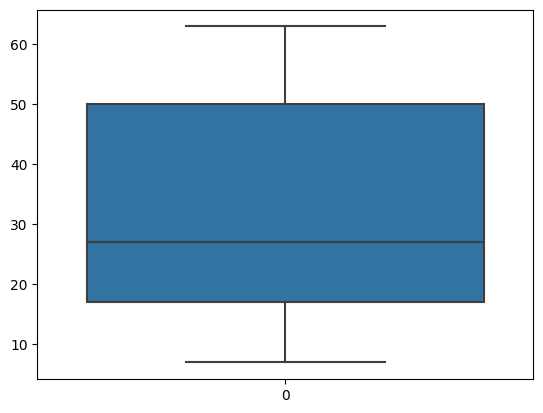

In [ ]:
plt.figure()
sns.boxplot(df_tokens['nb_tokens'].values)
plt.show()

After multiple adjustments, the optimal range of tokens appears to be between 7 and 70 tokens.

### Initial Filtering

After specifying the file containing our dataset, we load its contents into a `DataFrame` object. Some additional filtering is done on the dataset to eliminate rows:

* **Minimum Tokens**: We  filter out webpages that to not have the required minimum of tokens.
* **Maximum Tokens**: We also filter out webpages that have an outsized number of tokens,
* **Maximum Number of N-Grams**: The number of n-grams to include in our `CountVectorizer` object,
* **Non-English Webpages**: We only consider webpages written in English.

In [13]:
#@title Filtering Options
min_tokens = 7 #@param { type:"integer" }
max_tokens = 70 #@param { type:"integer" }
max_words = 250 #@param { type:"integer" }
english_only = True #@param { type:"boolean" }

We then perform some additional cleaning and filtering on the dataset generated. 

In [14]:
%%capture
# Remove rows containing foreign languages
if english_only and 'is_english' in df_features:
    df_features = df_features[df_features['is_english'] == True]

# Drop unneeded columns
if 'is_english' in df_features:
  df_features.drop('is_english', axis=1, inplace=True)

if 'title_raw' in df_features:
  df_features.drop('title_raw', axis=1, inplace=True)
  
# Keep rows with at the required amount of tokens
df_features = df_features[(df_features['nb_tokens'] >= min_tokens) &  (df_features['nb_tokens'] <= max_tokens)]

# Remove misclassified rows
df_features = df_features[(df_features['classification'] == 'benign') | (df_features['classification'] == 'malicious')]

# Remove strings containing special characters or
# misparsed HTML tags and code.
df_features['text_clean'] = df_features['text_clean'].str.replace('_',' ',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('//',' ',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('javascript','',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('https','',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('http','',regex=True)

### Dataset Information

We can now verify the remaining number of rows in our dataset. Using the sample of 20,000 websites results in a small dataset of 8,205 rows, which is relatively small. In a production environment, we would be using the full dataset of 380,000 samples, but for the sake of demonstrating the process, we will keep this small set for now.

#### Size

In [15]:
print(f"The features dataset contains {df_features.shape[0]} rows and {df_features.shape[1]} columns.")

The features dataset contains 8205 rows and 47 columns.


#### Empty Columns

In [16]:
df_features.isnull().sum()

title_clean           1034
img_count                0
has_form                 0
has_login_form           0
has_js                   0
js_include_b64           0
nb_tokens                0
text_clean               0
classification           0
nb_title_entities        0
nb_text_entities         0
jpmorgan_chase           0
bank_of_america          0
wells_fargo              0
hsbc                     0
deutsche_bank            0
mitsubishi_ufj           0
citibank                 0
rbc                      0
paypal                   0
scotiabank               0
apple                    0
microsoft                0
amazon                   0
google                   0
samsung                  0
facebook                 0
steam                    0
netflix                  0
ups                      0
fedex                    0
dhl                      0
tnt                      0
usps                     0
royal_mail               0
purolator                0
canada_post              0
y

#### Labels

By reviewing the labels, we notice that there is a larger number of malicious samples than benign ones, which may require us to consider when generating our classifier to have a more balanced distribution.

<Axes: >

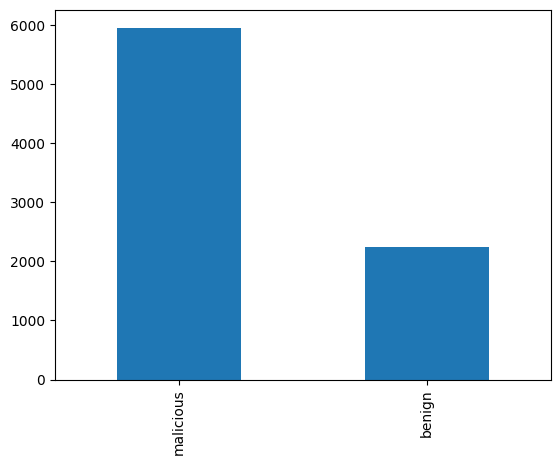

In [17]:
import matplotlib.pyplot as plt

# Assume "df" is your DataFrame object
classification_counts = df_features['classification'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')


#### Form Data

<Axes: >

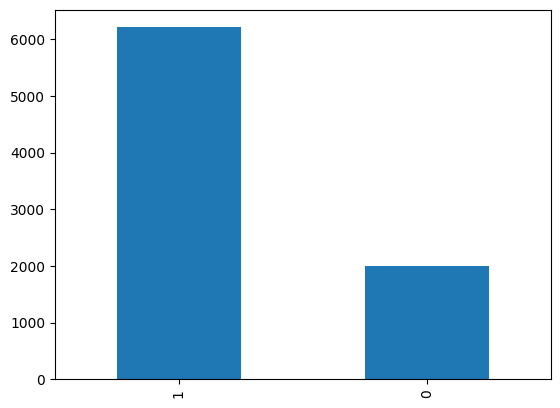

In [18]:
import matplotlib.pyplot as plt

# Assume "df" is your DataFrame object
classification_counts = df_features['has_form'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')

<Axes: >

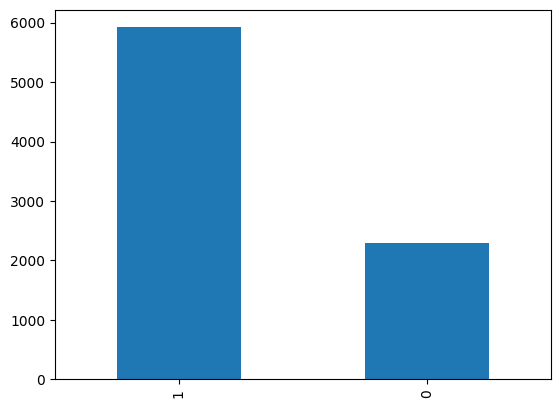

In [19]:
import matplotlib.pyplot as plt

# Assume "df" is your DataFrame object
classification_counts = df_features['has_login_form'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')

#### JavaScript Data

The presence of JavaScript from webpages is collected. _JavaScript_ is widely used on many webpages to provide dynamic content. It can also be used for cross-site scripting and inject remote malicious code in the page.

<Axes: >

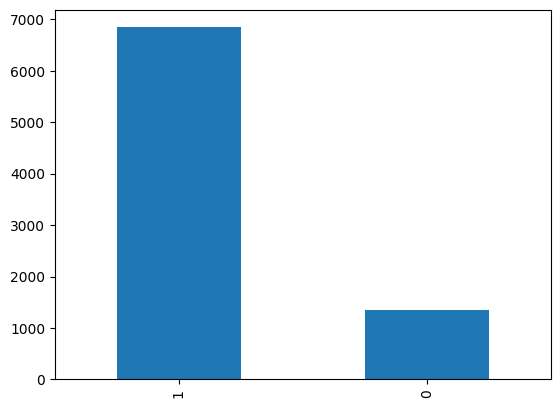

In [20]:
import matplotlib.pyplot as plt

# Assume "df" is your DataFrame object
classification_counts = df_features['has_js'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')

We collect information about the presence of Base64 encoded-string in webpages. _Base64_ is often used to obfuscated malicious JavaScript code. While this is not common, when this feature is present, there may be a high correlation between this feature the malicious webpages.

<Axes: >

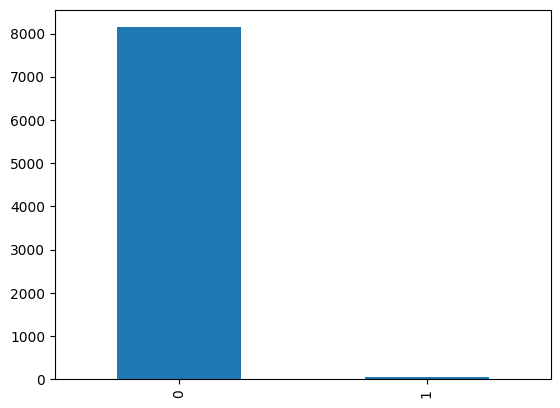

In [21]:
import matplotlib.pyplot as plt

# Assume "df" is your DataFrame object
classification_counts = df_features['js_include_b64'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')

### Text Analysis Model

The focus is then shifted into analysing the tokens extracted from the text of each websites remaining in the dataset.

#### Stop Words

After multiple iterations, custom stop words were included from the default English stop words from the `ntlk` framework. These includes:

* **ccTLDs**. Country-Coded Top-Level Domains associated with URLs embedded in some webpages. While the entire URL is useful, the country code, by itself, is not;
* **HTML tags**. Despite the parser's best efforts, some HTML tags remain embedded in the code. As such, we try to reduce some of the HTML code left behind;
* **Adverbs**. Some adverbs, such as _also_ or _may_ are not useful to the analysis.

In [22]:
from nltk.corpus import stopwords

# Load the default list of English stop words
default_stop_words = stopwords.words('english')

# Create the classifier
# Pass the complete dataset as data and the featured to be predicted as target
# Add custom stop words here:
custom_stop_words = ["com", "ca", "go", "td", "tr"
            "px", "co", "uv", "ru",
            "mx", "also", "use", "abc",
            "wo", "may", "oo", "javascript", "www",
            "html", "id", "class", "http", "https"]

# Append the custom list to the default list of stop words
stop_words = default_stop_words + custom_stop_words


Given our list of custom stop words, we then generate the `CountVectorizer` to create our matrix of word counts from the `text_clean` column of the `df_features` dataframe.

The tokens are focused on generating counts of 2 and 3-grams. This is because many of the phishing sites appears to re-used common terms that provide more context when considered as 2-grams. For example, "Sign Up", "Log In", "Reset Password" etc.... We also ignore tokens that have very low frequencies or very high frequencies. In this case, we used 1.5% and 80% based on other models reviewed. More research would be required to determine if this range is maximal.

The `csr_matrix` generated by the `CountVectorizer` is then converted into a `pandas.DataFrame` to be used with the `setup` function of `pycaret`.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a custom token pattern that matches only alphabetic characters
pattern = r'\b[A-Za-z]+\b'

# Create a CountVectorizer
# We keep only bigrams and trigrams
# We remove words not withing the [.015, 0.8] frequency
count_vectorizer = CountVectorizer(min_df=.015, 
                                   max_df=0.8, 
                                   stop_words=stop_words, 
                                   max_features=max_words, 
                                   ngram_range=(2, 3),
                                   token_pattern=pattern)

# Fit the vectorizer to the text data and transform the data
X = count_vectorizer.fit_transform(df_features['text_clean'])

df_words = pd.DataFrame(data=X.toarray(), columns = count_vectorizer.get_feature_names_out())

df_words.head()

,access account,account account,account account create,account another,account another account,account create,account create one,account doe,account doe n,account enter,...,webmail mini,webmail welcome,went wrong,went wrong dont,would like,would like proceed,wrong dont,wrong dont fret,yes something,yes something went
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We then generate the `DataFrame` object to be used to train our classifier by combining the features extracted and the n-gram vector.

In [24]:
# Reset the index of the two DataFrames
df_features.reset_index(drop=True, inplace=True)
df_words.reset_index(drop=True, inplace=True)

# Concatenate the 2 `DataFrame` to generate the dataset
df = pd.concat([df_features, df_words], axis=1)

print(f"The features data frame contains {df_features.shape[0]} row(s) and {df_features.shape[1]} column(s).")
print(f"The word vector contains {df_words.shape[0]} row(s) and {df_words.shape[1]} column(s).")
print(f"The resulting dataframe contains {df.shape[0]} row(s) and {df.shape[1]} column(s).")

The features data frame contains 8205 row(s) and 47 column(s).
The word vector contains 8205 row(s) and 250 column(s).
The resulting dataframe contains 8205 row(s) and 297 column(s).


## Model Generation

With the `DataFrame` containing all the features generated, we use to generate a model to match the label defined in the `classification` column.

In [25]:
#@title Classifier Options
sid = 1337 #@param {type:"integer"}
training_size = 0.85 #@param { type:"number" }

To avoid generating the _"Numba needs NumPy 1.20 or less"_ exception, we ensure the `numba` package is upgraded before doing anything else.

In [26]:
%%capture
!pip install numba --upgrade

### Create the Classifier

We can then generate our classifier object using the following options:
* `transformation`.
* `normalize`.
* `fix_imbalance`. Since we have more sites labeled as malicious, we ask `pycaret` to consider potential sample imbalances.
* `remove_perfect_collinearity`.

In [27]:
from pycaret.classification import *

# Create a PyCaret Classification experiment
clf = setup(data=df,
            session_id=sid,
            transformation=True, 
            normalize=True,
            fix_imbalance=True,
            #remove_perfect_collinearity=True,
            train_size=training_size,
            target="classification")

,Description,Value
0,Session id,1337
1,Target,classification
2,Target type,Binary
3,Target mapping,"benign: 0, malicious: 1"
4,Original data shape,"(8205, 297)"
5,Transformed data shape,"(11361, 297)"
6,Transformed train set shape,"(10130, 297)"
7,Transformed test set shape,"(1231, 297)"
8,Numeric features,294
9,Categorical features,2


### Select Model

In [28]:
# Compare multiple models and select the best
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9459,0.9591,0.9759,0.9511,0.9633,0.8608,0.8622,2.8800
et,Extra Trees Classifier,0.9459,0.9735,0.9759,0.9512,0.9633,0.8607,0.8621,3.1410
knn,K Neighbors Classifier,0.9249,0.9390,0.9477,0.9489,0.9483,0.8111,0.8113,1.9410
lr,Logistic Regression,0.9224,0.9677,0.9380,0.9547,0.9461,0.8075,0.8087,9.1360
ridge,Ridge Classifier,0.9214,0.0000,0.9418,0.9500,0.9457,0.8035,0.8046,1.0330
lda,Linear Discriminant Analysis,0.9213,0.9642,0.9416,0.9500,0.9456,0.8032,0.8043,1.9540
dt,Decision Tree Classifier,0.9125,0.8962,0.9325,0.9464,0.9393,0.7829,0.7837,1.4360
xgboost,Extreme Gradient Boosting,0.9105,0.9591,0.9238,0.9515,0.9372,0.7817,0.7838,13.0280
svm,SVM - Linear Kernel,0.9100,0.0000,0.9177,0.9569,0.9367,0.7810,0.7839,1.5610
gbc,Gradient Boosting Classifier,0.9038,0.9643,0.9161,0.9496,0.9320,0.7674,0.7707,4.8420


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

During the comparison, the top 2 classifier identified by `pycaret` are the _rf_ and _ridge_ classifiers. The _rf_ classifier reached an accuracy of 97.3%, a recall of 98.3% and precision of 97.9%. The _ridge_ classifier obtain 97.0% accuracy, a 97.9% recall but has a higher precision rate at 98.3% but an AUC value of 0%! Indicating potential issues with the balance of benign/malicious site ratio, made worst by our small sample. The _et_ classifier is therefore more of a legitimate model in this specific project.

#### Random Forest Classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9470,0.9740,0.9625,0.9644,0.9635,0.8669,0.8669
1,0.9499,0.9771,0.9724,0.9591,0.9657,0.8724,0.8727
2,0.9456,0.9492,0.9783,0.9484,0.9631,0.8594,0.8609
3,0.9427,0.9606,0.9724,0.9499,0.9610,0.8530,0.8538
4,0.9397,0.9428,0.9803,0.9395,0.9595,0.8423,0.8452
5,0.9225,0.9139,0.9763,0.9216,0.9482,0.7953,0.8005
6,0.9512,0.9763,0.9723,0.9609,0.9666,0.8762,0.8764
7,0.9613,0.9763,0.9901,0.9579,0.9738,0.8999,0.9017
8,0.9570,0.9744,0.9783,0.9630,0.9706,0.8904,0.8908


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

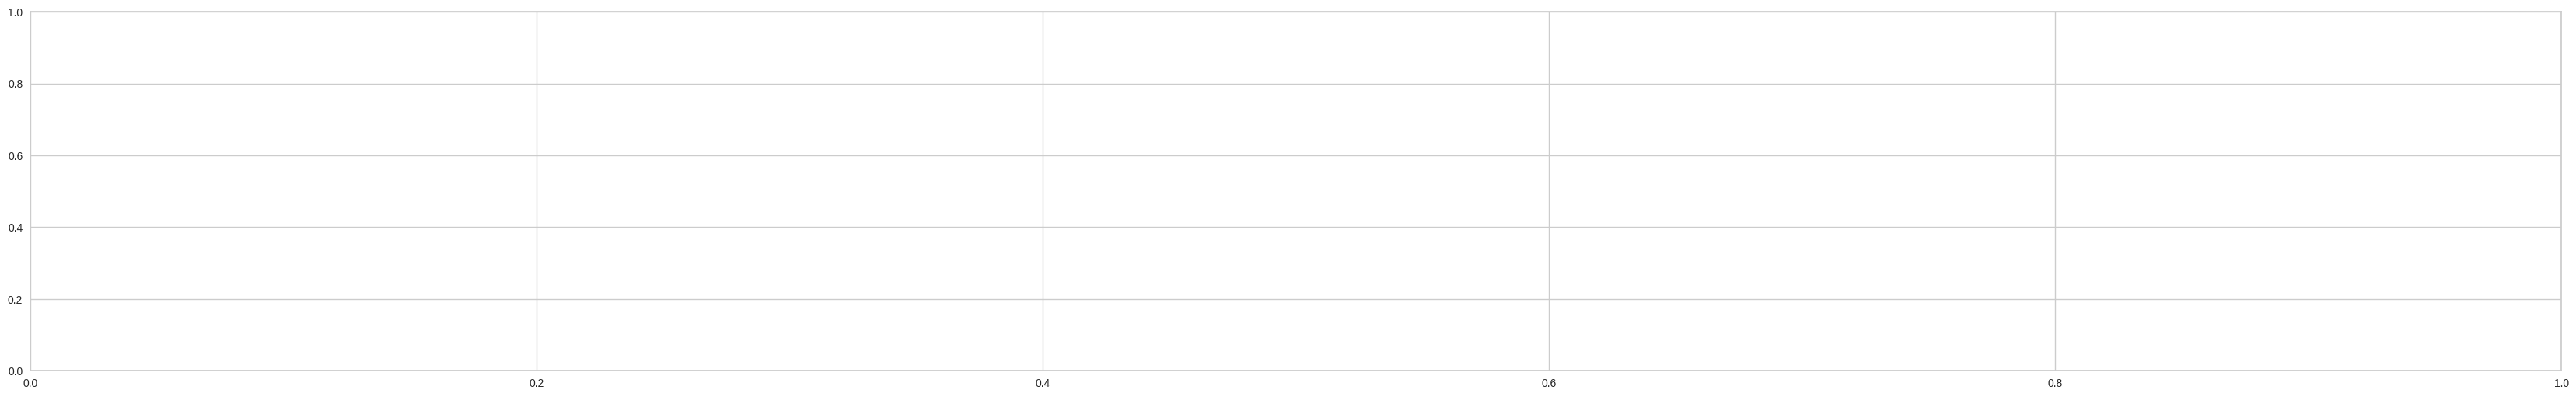

In [29]:
m_rf = create_model("rf")
evaluate_model(m_rf)

#### Extra Trees Classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9484,0.9766,0.9665,0.9627,0.9646,0.8698,0.8699
1,0.9527,0.9877,0.9724,0.9629,0.9676,0.8801,0.8802
2,0.9384,0.9690,0.9763,0.9411,0.9584,0.8401,0.8422
3,0.9441,0.9791,0.9704,0.9535,0.9619,0.8573,0.8578
4,0.9369,0.9585,0.9803,0.9360,0.9576,0.8343,0.8377
5,0.9197,0.9508,0.9743,0.9198,0.9463,0.7877,0.7928
6,0.9541,0.9798,0.9763,0.9611,0.9686,0.8831,0.8835
7,0.9627,0.9804,0.9921,0.9580,0.9748,0.9034,0.9054
8,0.9598,0.9818,0.9783,0.9668,0.9725,0.8980,0.8983


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

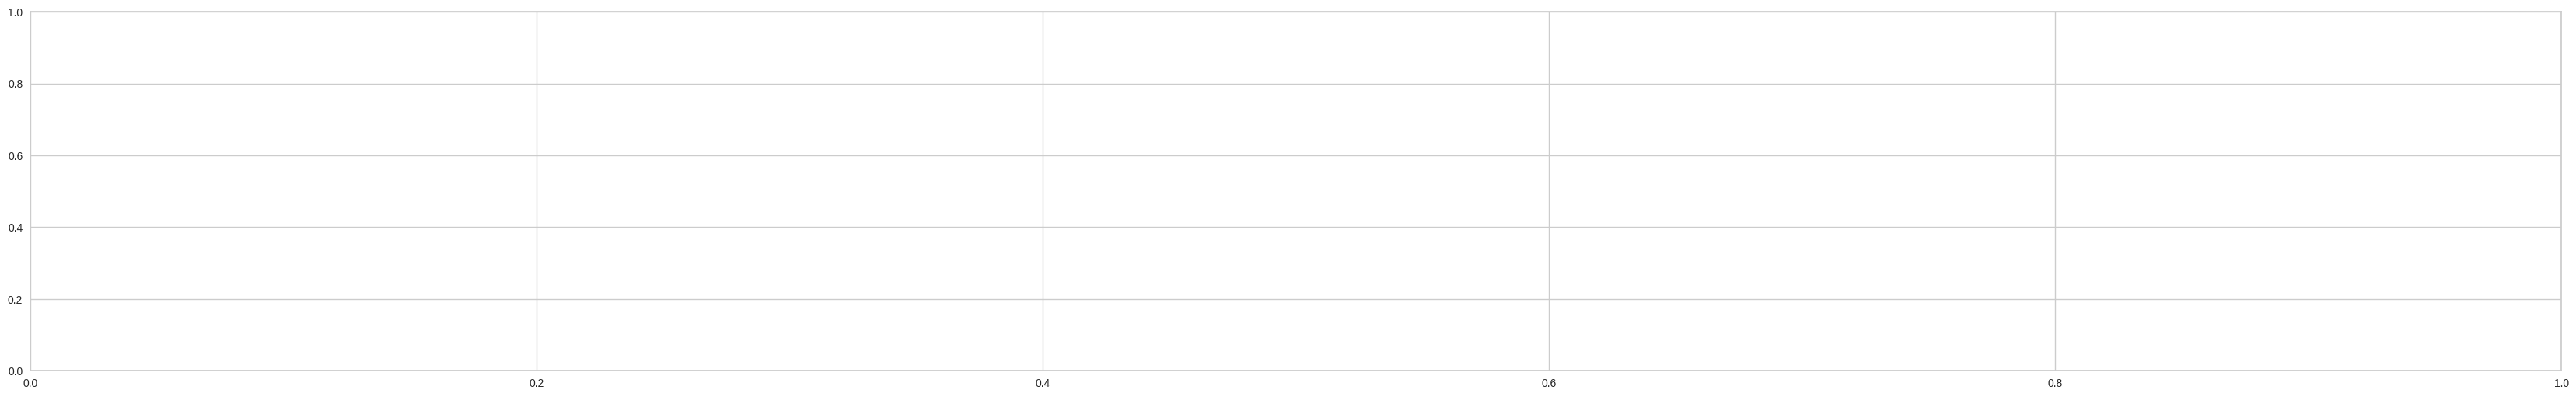

In [30]:
m_et = create_model("et")
evaluate_model(m_et)

### Finalize Model

Some of the key observations made by comparing the _rf_ and _et_ models are enumerated here:

* Both confusion matrix are similar and are tilted towards the detection of malicious websites.
* An AUC of 0% while having a high precision number for the _ridge_ model is likely indicating an imbalance, despite asking `pycaret` to fix it when creating the classifier.

Since both confusion matrix are similar and the _rf_ model has higher accuracy, we select the _rf_ model. Again, it is important to reiterate that the small sample size is very likely affecting the current results, and the full sample set would be used in the end-product, possibly resulting in the selection of a different model.


In [31]:
# Specify the best model here:
best_model = m_rf

# Finalize the best model
final_model = finalize_model(tune_model(best_model))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9011,0.9615,0.9053,0.9562,0.9301,0.7618,0.7651
1,0.9169,0.9642,0.9231,0.9610,0.9416,0.7976,0.7995
2,0.9054,0.9511,0.9211,0.9473,0.9340,0.7674,0.7684
3,0.8968,0.9555,0.8895,0.9657,0.9261,0.7564,0.7634
4,0.9024,0.9398,0.9290,0.9364,0.9327,0.7556,0.7557
5,0.8953,0.9277,0.9190,0.9356,0.9272,0.7406,0.7410
6,0.9254,0.9683,0.9269,0.9690,0.9475,0.8190,0.8214
7,0.9469,0.9676,0.9625,0.9644,0.9634,0.8668,0.8668
8,0.9254,0.9645,0.9269,0.9690,0.9475,0.8190,0.8214


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Export Models

When ready, we can export our models. The code below will create two (2) files:

1. CountVectorizer model. The `CountVectorizer` model used to generate the word count vector;
1. Classifier model The classifier model.

In [32]:
%%capture
import os
import pickle
from datetime import datetime

# Generate a file name based on the current date and time
now = datetime.now().strftime("%Y%m%d-%H%M%S")

vector_file_name = f"vector-{now}.pkl"
class_file_name = f"class-{now}"

vector_file_path = os.path.abspath(os.path.join(".", vector_file_name))
class_file_path = os.path.abspath(os.path.join(".", class_file_name))

# Save the fitted vectorizer as a pickle file
with open(vector_file_name, 'wb') as f:
    pickle.dump(count_vectorizer, f)

# Save the best model to a file
save_model(final_model, class_file_path)


## Testing

This section provides the code required to test the model generated on unseen data by providing a URL and assess whether its contents are "benign" or "malicious". You can specify the model files to use below:

In [45]:
#@title Models
vector_model_file = "vector-20230405-132845" #@param {type:"string"}
class_model_file = "class-20230405-132845" #@param {type:"string"}

### Requirements

The following modules are required:

In [34]:
%%capture
%pip install langdetect

### Parsing

The code below will parse a webpage and extract the required features for the analysis.

In [43]:
%%capture
import os
import re
import string
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from langdetect import detect

nltk.download('punkt')
nltk.download('stopwords')
#
# Define a function to check the method attribute
def is_post(form):
    return form.get('method', '').lower() == 'post'
#
def remove_non_displayable(text):
    printable_chars = set(string.printable)
    return ''.join(filter(lambda x: x in printable_chars, text))
#
def parse_html(html:str) -> dict:
      features = {}
      soup = BeautifulSoup(html, 'html.parser')
      # get the title of the webpage
      if soup.title is not None and soup.title.string is not None:
          wp_title = remove_non_displayable(soup.title.string.strip().lower())
          features["title_raw"] = " ".join(nltk.word_tokenize(wp_title))
      else:
          features["title_raw"] = ""
      # Extract the text content from the HTML
      text = remove_non_displayable(soup.get_text())

      try:
          features["is_english"] = (detect(text) == "en")
      except:
          # If we cannot detect the language, it's probably not useful or
          # english, so we'll labelled it as non-english
          features["is_english"] = False

      # search for a login form
      forms = soup.find_all('form', {'method': 'POST'})
      forms += soup.find_all('form', {'method': 'post'})
      features["has_form"] = len(forms) > 0
      features["has_login_form"] = len(soup.find_all("input", {"type": "password"})) > 0

      # Check if JavaScript with base64 strings exists
      scripts = soup.find_all('script')
      features["has_js"] = (len(scripts) > 0)
      features["js_include_b64"] = False
      for script in scripts:
          if script.has_attr('src'):
              # Check if script is loaded from external source
              script_content = None
          else:
              script_content = script.string

          if script_content is not None and re.search("data:[a-zA-Z0-9+/]+={0,2}", script_content):
              features["js_include_b64"] |= True

      # tokenize the text after convertign to lowercase
      tokens = nltk.word_tokenize(text.lower().strip())

      # remove stop words and punctuation
      stop_words = set(stopwords.words('english'))
      clean_tokens = [token for token in tokens if token.lower() not in stop_words and token not in string.punctuation]
      # Save the number of tokens
      features["nb_tokens"] = len(clean_tokens)

      # join the cleaned tokens back into a string
      features["text_clean"] = ' '.join(clean_tokens)
      return features

In [36]:
#@title URL
url = "https://google.com" #@param {type:"string"}

### Evaluate URL

Run the code block below to evaluate the URL provided. If the website is accessible, the code will return either "BENIGN" or "MALICIOUS" based on its contents.

In [ ]:
import os
import requests
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
from pycaret.classification import *

if not os.path.isfile(f"{vector_model_file}.pkl"):
  raise(Exception(f"[-] File not found: {vector_model_file}.pkl"))
elif not os.path.isfile(f"{class_model_file}.pkl"):
  raise(Exception(f"[-] File not found: {class_model_file}.pkl"))

with open(f"{vector_model_file}.pkl", 'rb') as f:
    count_vectorizer = pickle.load(f)

class_model = load_model(class_model_file)

response = requests.get(url)
if response.status_code == 200:
  html = response.text
  print(f"[+] Received {len(html)} byte(s) from '{url}'.")
  f = parse_html(html)
  if f["is_english"] is True:
    # Generate a `DataFrame` from the features extracted
    df_features = pd.DataFrame([f])

    # Drop unneeded columns
    df_features.drop('is_english', axis=1, inplace=True)
    df_features.drop('title_raw', axis=1, inplace=True)

    # Vectorize the website content using the pre-trained count vectorizer
    X = count_vectorizer.transform(df_features["text_clean"])

    df_words = pd.DataFrame(data=X.toarray(), columns = count_vectorizer.get_feature_names_out())

    # Merge dataframes together
    df = pd.concat([df_features, df_words], axis=1)

    prediction = predict_model(class_model, data=df)
    label = prediction.iloc[-1]["Label"]
    
    print(f"Classification: {label.upper()}")
  else:
    print(f"[-] Target website is not written in English.")
else:
  print(f"[-] Received response '{response.status_code}' from '{url}'.")



## Observations

The initial implementation of the project attempted to leverage the `pycaret.nlp` project and assign topics to each website using the "LDA" and "NMF" techniques. However, many issues were met:

1. Many dependencies and version issues within `pycaret.nlp`, along with dependencies issues with `numpy` and `nltk` made replication of experiments difficult. Given the approaching deadline, an executive decision was made to revert to `scikitlearn` and leverage simpler techniques, i.e. word count vector
1. When we were able to make `pycaret.nlp` work, many websites were not assigned a topic. This was especially true for malicious websites. This is despite increasing the minimum number of tokens up to 20 and using up to 30 topics. It is suspected that unclean parsing of HTML code was creating a very large word cloud, limiting the effectiveness of such models.

Hence, using `scikit` and a simple word vector was a simpler solution, easily replicable and apparently more effective in detecting malicious sites. 

## Future Improvements

Additional features could be extracted that would be interesting to enrich the model. These include:

* Include the title of the webpage to detect tokens of interest, including names of organizations
* Include features about the URL itself, i.e. length, ccTLD, special characters, string entropy.
* Include information about specific HTML tags, i.e. presence of `<iframe>` `<img>`;
* Extend the extraction of features to JavaScript linked via `src` attributed.

In terms of improving the NLP aspect of this project, the following activities would be interesting to pursue:

* Use the full dataset for training the model, i.e. 382,000 webpages;
* Better parsing of HTML to filter out remaining HTML code.
* Add emphasis on the detection of organizations, i.e. Bank of America, Microsoft, Facebook etc..

Lastly, the work presented would benefit from performing a deeper evaluation of models to ensure that the model chosen by `pycaret` is truly optimal and better understand the hyperparameter requiring tuning. A lot of the heavy lifting was left to `pycaret` for this project.

## Conclusion

The project could be commercialized as a plugin for email client or as a browser extension. For example, an Outlook add-on could be developed to detect URLs in inbound emails, retrieve a copy of the website and provide a rating and/or label about the probability of the link to be a phish. A similar concept could be implemented by developing a browser plugin. When a user browses a website, the plugging could send the contents of the website back to an API which could return the appropriate label and if the site is classified as malicious, a warning could be displayed on the site.

### Questions

If you have any question about the topics discussed in this notebook, feel free to contact me. Use the YorkU course page to retrieve my email address and reach out.